Supervisor Agent: Receives customer inquiries.

Worker Agents:
    OrderAgent: Handles questions about order status, tracking, or history (could interact with a dummy order database or API). (SQL)
    TechnicalSupportAgent: Provides basic troubleshooting steps or directs users to documentation.(Rag)
    FAQAgent: Answers common questions based on a knowledge base.(Web Search)
    HelpAgent: Human in loop

In [1]:
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain import hub
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
import sqlite3

from dotenv import load_dotenv

load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite")
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
tavily_search = TavilySearchResults(max_results=2)

In [114]:
def get_engine_for_chinook_db():
    """Read local sql file, populate in-memory database, and create engine."""
    with open('customer_orders.sql', 'r') as file:
        sql_script = file.read()

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )


engine = get_engine_for_chinook_db()

db = SQLDatabase(engine)

In [152]:
url = WebBaseLoader([
    "https://jmp.sh/s/xytMC8GRMqFt3qmbIRL7",])

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=20,
)

doc_splits = text_splitter.split_documents(url.load())

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [153]:
from langchain_core.prompts import  ChatPromptTemplate
class Format_document(BaseModel):
    """Format the retrieved documents."""

    extracted_field: str = Field(
        description="Extract the relevant field from the document.",
    )
structured_llm_grader = llm.with_structured_output(Format_document)

system = """
    
"""

grade_prompt = ChatPromptTemplate(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
my_retrieval_grader = grade_prompt | structured_llm_grader

In [154]:
class Supervisor(BaseModel):
    next: Literal["order", "web_search_node", "support", "human_node"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'order' searches through the db using sql commands to give a proper response, "
                    "'support' when the user is looking for a specific information about license, terms and conditions, data privacy, etc., "
                    "'web_search_node' when asked about current or additional information available on the web, "
                    "'human_node' when none of the other agents are able to give a proper response, "
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

def supervisor_node(state: MessagesState) -> Command[Literal["order", "web_search_node", "support", "human_node"]]:

    system_prompt = ('''
                 
        You are a workflow(Customer Support Inquiry Router and Responder) supervisor managing a team of four specialized agents: Order, web, support and human helper. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Order**: Handles order-related inquiries, including order status, tracking, and modifications. This agent is equipped to search through the database using SQL commands to provide accurate information.
        2. **support**: Addresses frequently asked questions, such as license information, terms and conditions, and data privacy. This agent is knowledgeable about company policies and can provide detailed responses.
        3. **web_search_node**: Engages with users seeking current or additional information available on the web. This agent is adept at searching the internet for up-to-date information and resources.
        4. **human_node**: Acts as a fallback option when the other agents are unable to provide a satisfactory response. This agent is designed to handle complex inquiries that require human intervention or further escalation.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.

    ''')

    messages = [{"role": "system", "content": system_prompt}] + state["messages"] 

    response = llm.with_structured_output(Supervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto} ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,
    )

In [155]:
def order_node(state: MessagesState) -> Command[Literal["validator"]]:

    """
    This function is responsible for handling order-related inquiries. It utilizes SQL commands to search through the database and provide accurate information to the user.
    The function is designed to be invoked when the user request is related to order status, tracking, or modifications. It ensures that the response is relevant and accurate by leveraging the capabilities of the SQLDatabaseToolkit.
    """

    prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

    system_message = prompt_template.format(dialect="SQLite", top_k=5)

    toolkit = SQLDatabaseToolkit(db=db, llm=llm)

    agent_executor = create_react_agent(llm, toolkit.get_tools(), prompt=system_message)

    result = agent_executor.invoke(state)

    print(f"--- Workflow Transition: Order Node → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="order"  
                )
            ]
        },
        goto="validator", 
    )

In [156]:
def support_node(state: MessagesState) -> Command[Literal["validator"]]:
    
    """
    This function takes the retriever i.e., Chroma vectorstore and the user query to search for relevant documents.
    """
    
    # Extract the user query from the last message
    user_query = state["messages"][-1].content
    
    # Invoke the retriever with the user query string
    retrieved_docs = retriever.invoke(user_query)
    
    # Combine the content of the retrieved documents
    combined_content = "\n\n".join([doc.page_content for doc in retrieved_docs])
    
    print(f"--- Workflow Transition: Support Node → Validator ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=combined_content,  # Use combined content
                    name="support"  
                )
            ]
        },
        goto="validator", 
    )

In [157]:
def web_search_node(state: MessagesState) -> Command[Literal["validator"]]:

    """
    This function is responsible for handling web search inquiries. It utilizes the TavilySearchResults tool to search the web for current or additional information based on the user's query.
    The function is designed to be invoked when the user request is related to finding up-to-date information or resources available on the web. It ensures that the response is relevant and accurate by leveraging the capabilities of the TavilySearchResults tool.
    """
    
    research_agent = create_react_agent(
        llm,  
        tools=[tavily_search],  
        state_modifier= "You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
            "1. Identifying key information needs based on the query context\n"
            "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
            "3. Organizing findings in a structured, easily digestible format\n"
            "4. Citing sources when possible to establish credibility\n"
            "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
            "Provide thorough, factual responses without speculation where information is unavailable."
    )

    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: web_search → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="web_search_node"  
                )
            ]
        },
        goto="validator", 
    )

In [158]:
def human_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    This function is responsible for handling user messages that require human intervention or further escalation.
    It is designed to be invoked when the other agents are unable to provide a satisfactory response.
    """
    input_msg = (
        'Please rephrase the question to be more specific and clear.\n\n'
    )
    resp = input(input_msg)

    print(f"--- Workflow Transition: human_node → Supervisor ---")

    if resp:
        return Command(
            update={
                "messages": [ 
                    HumanMessage(
                        content=resp,  
                        name="human_node"  
                    )
                ]
            },
            goto="supervisor", 
        )

In [159]:
system_prompt = '''
    Your task is to ensure reasonable quality. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
    - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
    - Accept answers that are "good enough" rather than perfect
    - Prioritize workflow completion over perfect responses
    - Give benefit of doubt to borderline answers
    
    Routing Guidelines:
    1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
    2. Respond with 'FINISH' in all other cases to end the workflow.
'''

class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END  
        print(" --- Transitioning to END ---")  
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

In [160]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node) 
graph.add_node("order", order_node)
graph.add_node("support", support_node)
graph.add_node("web_search_node", web_search_node) 
graph.add_node("human_node", human_node) 
graph.add_node("validator", validator_node)  

graph.add_edge(START, "supervisor")  
app = graph.compile()

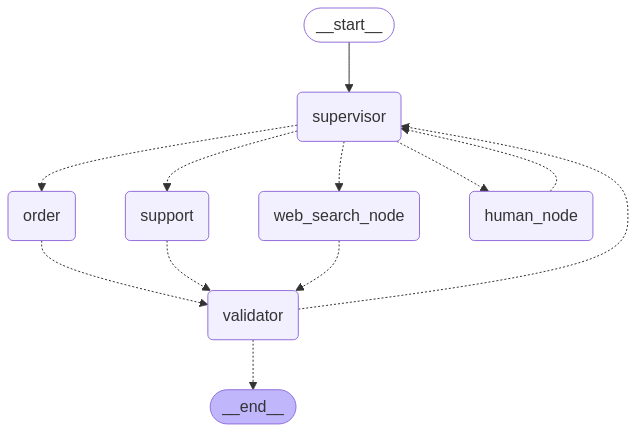

In [161]:
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

In [164]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

--- Workflow Transition: Supervisor → web_search_node ---
((), {'supervisor': {'messages': [HumanMessage(content='The question is a mathematical calculation, so I will use the web_search_node to find the answer.', additional_kwargs={}, response_metadata={}, name='supervisor')]}})
----
(('web_search_node:3dda072d-49bc-af4c-f256-0742a3fb2128',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "square root of 42"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run-6ed61d03-8e8b-4fb1-bd5a-dbfb5557a9ea-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square root of 42'}, 'id': 'e1bbbca8-4fad-446b-b0c6-50f0a322ed4a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 175, 'output_tokens': 15, 'total_tokens': 190, 'input_token_details': {'cac

In [163]:
for s in app.stream({"messages": [("user", "what is the total number of orders taken and sum amount")]}, subgraphs=True): 
    print(s)
    print("----")

--- Workflow Transition: Supervisor → order ---
((), {'supervisor': {'messages': [HumanMessage(content="The user is asking for order-related information (total number and sum amount), which requires querying the order database. The 'order' agent is best equipped to handle this using SQL queries to retrieve the requested data directly from the database..", additional_kwargs={}, response_metadata={}, name='supervisor')]}})
----


c:\Users\abhis\OneDrive\Desktop\New folder\langgraph\env\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


(('order:7b705e16-44c2-4604-d88d-4744e8748b66',), {'agent': {'messages': [AIMessage(content='Okay, I will start by listing the tables in the database to understand what tables are available for querying order information.', additional_kwargs={'function_call': {'name': 'sql_db_list_tables', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run-daacfb70-a5e6-437d-82ce-236452d927c9-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'b3736b66-8f1b-4ab4-9cec-a6172ea4002e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 562, 'output_tokens': 31, 'total_tokens': 593, 'input_token_details': {'cache_read': 0}})]}})
----
(('order:7b705e16-44c2-4604-d88d-4744e8748b66',), {'tools': {'messages': [ToolMessage(content='customers', name='sql_db_list_tables', id='b1016fde-854a-4290-99b5-938a6aa6ee31', tool_call_id='b3736b66-8f1b-4ab4-9cec-a